# [GD07] Seq2seq 기반 번역기 만들기
# 8-1. 들어가며

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-1.max-800x600.jpg)

이전 시간에 멋진 Sequence-to-Sequence 구조를 배웠습니다. 두 개의 RNN 모듈을 Encoder-Decoder 구조로 결합하여 사용하는 Seq2seq은 그야말로 혁신이었습니다.

Seq2seq이 번역기에 최적화되어 있는 만큼, 이번 코스에선 Seq2seq 기반 번역기를 직접 만들어보며 그 구조를 이해해보도록 하겠습니다. 또한 Attention 기법을 추가하여 성능을 높여보기도 할 거고요!

실습에는 영어-스페인어 말뭉치를 사용하지만 직접 하실 프로젝트는 한국어-영어 말뭉치를 사용할 것입니다. 그럼 시작합시다!

## 준비물
터미널을 열고 프로젝트를 위한 디렉토리를 생성해 주세요.
```
$ mkdir -p ~/aiffel/s2s_translation
```

실습에서는 한국어가 포함된 말뭉치를 사용하므로, 한국어를 잘 시각화하기 위한 준비가 필요합니다. 다만 matplotlib 라이브러리의 기본 폰트는 한국어를 지원하지 않아요! 올바른 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경해 주도록 합시다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


# 8-2. 데이터 전처리
## 데이터 준비하기
먼저 프로젝트에 사용될 라이브러리를 import 하도록 합시다.

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


데이터를 다운로드하는 데에는 텐서플로우에서 제공하는 tf.keras.utils.get_file() 함수를 사용할 겁니다. get_file()함수는 URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제까지 알아서 할 수 있는 똑똑한 함수랍니다! 아래 소스를 실행해 데이터를 다운로드받아주세요.



In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


다운로드받은 데이터를 읽어온 후, 형태를 확인해보도록 하죠!



In [4]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


## 데이터 전처리: 정제하기
데이터는 \t 기호를 기준으로 영어와 스페인어가 병렬 쌍을 이루고 있습니다. 고로 \t 기호를 매개변수로 split() 함수를 호출하면 손쉽게 소스 문장과 타겟 문장을 분리할 수 있겠죠! 추가로 위 예시의 네 번째 문장을 보면 ¡ 같은 요상한 기호가 포함되어 있곤 합니다. 이 같은 특수문자는 불필요한 노이즈로 작용할 수 있기 때문에 정제 과정에서 삭제하도록 하겠습니다.

사실 스페인에서는 역 물음표(¿)와 역 느낌표(¡)를 일반적으로 사용합니다. 문장이 물음표나 느낌표로 끝난다면 해당 문장 맨 앞에 역으로 된 기호를 붙여준다고 해요. 이해를 돕기 위해 이상한 기호 취급을 하였으니 양해를 바랍니다!

정제는 아래 소스를 실행함으로써 진행할 수 있습니다.

In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 이전 렉처 노드에서 살펴보았듯, Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문입니다.

원활한 학습을 위해 데이터는 상위 3만 개만 사용하도록 하겠습니다.



In [7]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


## 데이터 전처리: 토큰화
정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환하세요. 그리고 변환된 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리하세요! (Tokenizer의 단어 수는 자유롭게 진행하세요!)

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [9]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


8-3. 모델 설계
이제부터 아래 그림처럼 각각 1개의 GRU을 갖는 Encoder-Decoder 구조를 설계할 겁니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-2.max-800x600.jpg)
[GRU 구조]

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.

Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

Attention은 Bahdanau을 사용할 예정이며, 이는 이전 렉처 노드에서 실습한 코드를 가져다가 쓰도록 할게요.

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


위 그림과 동일한 구조를 갖는 Encoder 클래스와 Decoder 클래스를 설계하고, 아래 소스를 실행해 답안과 같은 결과를 얻으세요.

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [14]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# 8-4. 훈련하기 (1) Optimizer & Loss
지금까지는 fit() 함수로 간편하게 학습을 진행했지만, Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해줘야 합니다. 조금 불편하고 난감하게 다가올 수도 있지만 후에 더 멋진 연구를 하기 위한 발판이 되어 줄 테니 익숙해져 봅시다!

낯선 함수들이 지나치게 많이 등장할 수 있으니, 이번 코스에선 직접 구현을 하기보단 구현체를 먼저 보고 이해하는 방향으로 공부하도록 합시다!

## Optimizer & Loss
가장 큰 줄기를 먼저 보고, 점점 더 들어가 보는 방식으로 진행해볼게요. 첫 순서는 Optimizer와 Loss입니다!

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법 정도로 설명할 수 있는데, 일반적으론 Adam 외의 것을 사용하지 않으니 후에 실력이 더 늘어나고 나서 공부하시는 것을 권장합니다! 우선은 다른 배워야 할 것들이 산더미니까요...😅

여기서 fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문입니다. 앞서 설명한 것처럼 Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 하기 때문이죠.

SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해줍니다. CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠. from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다. 우리는 True 로 줬으니 모델의 출력값을 그대로 전달하면 됩니다!

데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준으로 패딩(Padding) 과정을 거친 것을 기억하나요? tokenize() 함수 내부의 pad_sequences() 가 바로 그 역할을 해주는 녀석이었죠!

만약 모델에게 <PAD> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 <PAD> 로 이뤄져 있다고 생각하게 됩니다. 쉽게 말해 유난히 같은 답이 많은 객관식 시험이라고나 할까요...? 어떤 시험이 한 번호로만 찍어도 80점 이상을 받을 수 있다면 그 시험은 공부를 절대 하지 않겠죠! 모델은 심지어 10,000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기 때문에 패딩에 대한 처리를 해주지 않으면 <PAD> 토큰만을 생성할 확률이 굉장히 높아집니다.

이것은 종종 발생하는 문제라서 기억해두시면 좋아요. 이 문제를 방지하기 위해 mask 가 사용됩니다! mask 는 정답지에서 <PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해주죠. equal() 함수에 정확히는 0 이 아닌 <PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.

# 8-5. 훈련하기 (2) train_step 구현하기
train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다. 먼저 구성을 보시죠!

In [17]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


코드를 좀 더 자세히 살펴봅시다.

@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문이죠! 실제로 위 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요된답니다! 그러니 가능하다면 사용하는 쪽이 유리하겠죠? 아래는 @tf.function의 공식 문서입니다.

[텐서플로 2.0의 tf.function과 오토그래프 (AutoGraph) | TensorFlow Core](https://www.tensorflow.org/guide/function?hl=ko)

tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다. 이 또한 공식 문서를 첨부해드릴게요!

[그래디언트 및 자동 미분 소개 | TensorFlow Core](https://www.tensorflow.org/tutorials/customization/autodiff?hl=ko)

본론으로 돌아와서 train_step()의 학습 과정은 아래와 같습니다.

1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 <start> 토큰 문장 생성
4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!
코드를 한 줄 한 줄 살피면 이해가 어려운 라인은 없을 거예요.

# 8-6. 훈련하기 (3) 훈련 시작하기
다음 순서는 본격적으로 훈련을 시작하는 부분입니다! (훈련 시간은 약 15분 정도 소요 됩니다.)

In [18]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [01:32<00:00,  4.04it/s, Loss 0.1406]


먼저 tqdm은 훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리입니다. 사용법은 위 예제만 봐도 이해가 갈 정도로 정말 간단하니 웬만하면 활용하시는 것을 추천해 드려요! # tqdm이 붙은 라인은 모두 출력에 관련된 내용이니 설명을 생략하겠습니다. 궁금하신 분들은 아래 github을 참고하시길 바라요!

[tqdm/tqdm](https://github.com/tqdm/tqdm)

먼저 EPOCHS = 10 만큼 반복하는 루프에 진입한 후, 각 배치의 시작 인덱스를 idx_list 배열에 저장합니다. 그리고 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 하는데요, 인덱스를 섞어서 처리할 겁니다. 순차적인 인덱스로 데이터를 불러오는 게 아닌 랜덤한 인덱스로 데이터를 불러오는 것은 데이터를 섞는 것과 동일한 효과를 가져오겠죠!

그 후에 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수였죠!

이번 기회에 Encoder-Decoder 구조의 학습 방법을 마스터하세요! optimizer와 loss, train_step()까지 정의한 후 훈련을 시작하면 아래와 같은 결과를 확인할 수 있습니다.

```
Epoch  1: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s, Loss 1.3371]
Epoch  2: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s, Loss 0.8679]
Epoch  3: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s, Loss 0.6092]
Epoch  4: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s, Loss 0.4389]

...

Epoch  9: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s, Loss 0.1577]
Epoch 10: 100%|██████████| 375/375 [00:53<00:00,  7.06it/s, Loss 0.1417]
```

## 실습하기
이제 직접 실습해 볼까요?

Step 1에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의하세요! 그리고 train_step() 을 마친 후, 곧이어 eval_step() 을 진행하도록 소스를 수정하세요! 결과는 아래와 같은 형태가 되어야 합니다.

(주의! Evaluation 중에는 모델이 학습을 해서는 안 됩니다!)

```
Epoch  1: 100%|██████████| 375/375 [00:50<00:00,  7.45it/s, Loss 1.7839]
Test Epoch  1: 100%|██████████| 94/94 [00:09<00:00,  9.75it/s, Test Loss 1.4220]
Epoch  2: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s, Loss 1.2333]
Test Epoch  2: 100%|██████████| 94/94 [00:02<00:00, 46.58it/s, Test Loss 1.1305]
Epoch  3: 100%|██████████| 375/375 [00:31<00:00, 11.77it/s, Loss 0.9801]
Test Epoch  3: 100%|██████████| 94/94 [00:01<00:00, 48.42it/s, Test Loss 0.9771]
Epoch  4: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s, Loss 0.7998]
Test Epoch  4: 100%|██████████| 94/94 [00:02<00:00, 46.70it/s, Test Loss 0.8701]
Epoch  5: 100%|██████████| 375/375 [00:31<00:00, 11.81it/s, Loss 0.6553]
Test Epoch  5: 100%|██████████| 94/94 [00:01<00:00, 47.60it/s, Test Loss 0.7903]
...
```

In [20]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:04<00:00, 22.29it/s, Test Loss 0.7624]


훈련이 완료된 모델은 아래 소스를 실행해 번역 성능을 평가할 수 있어요. Attention Map을 시각화하는 것는 보너스!

/tmp/ipykernel_50/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_50/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: can i have some coffee ?
Predicted translation: me das un poco de caf ? <end> 


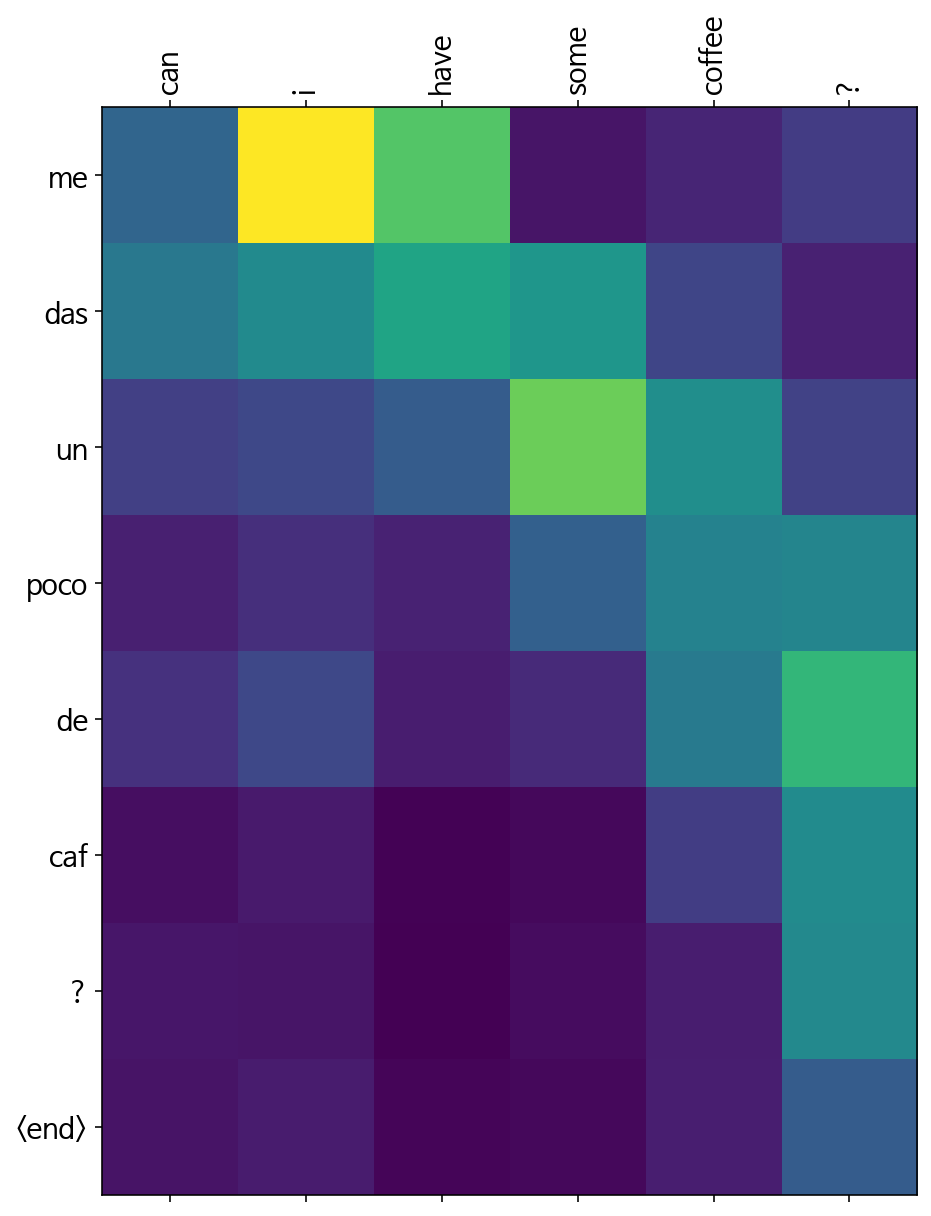

In [21]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

아래와 같은 맵이 나오면 성공입니다.

![attention map](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-4-P-3.jpg)

# 8-7. 프로젝트: 한영 번역기 만들기
라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [6]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


## Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

### 데이터 준비하기

In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [4]:
ko_path = os.getenv('HOME')+"/aiffel/s2s_translation/data/korean-english-park.train.ko"
en_path = os.getenv('HOME')+"/aiffel/s2s_translation/data/korean-english-park.train.en"

with open(ko_path, 'r') as f:
    kor = f.read().splitlines()
    
with open(en_path, 'r') as f:
    eng = f.read().splitlines()

print(len(kor))
print(len(eng))

94123
94123


In [7]:
corpus = pd.DataFrame([kor, eng], index=['kor', 'eng']).T

corpus

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


## Step 2. 데이터 정제
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

### 중복값 제거

In [8]:
cleaned_corpus = corpus.copy()

#### 2. 중복값 제거

In [9]:
cleaned_corpus.drop_duplicates(inplace=True)

In [10]:
cleaned_corpus

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [131]:
cleaned_corpus.dropna(how='any', inplace=True)
cleaned_corpus.reset_index(drop=True)

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


### preprocessing 한글 정규식 추가

먼저 앞서 불러온 preprocessing을 가져온다.

In [132]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"['¡°¡¦¡¯¡±]", "", sentence) 
    sentence = re.sub(r"([#*+-/:;<=>@\[\]\"^_`{|}~])", "", sentence)
    sentence = re.sub(r"([$%&()?!',.])", r" \1 ", sentence) 
    sentence = re.sub(r"[' ']+", " ", sentence)


    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [11]:
Row_list =[]
  
# Iterate over each row
for index, rows in cleaned_corpus.iterrows():
    # Create list for the current row
    my_list =[rows.kor, rows.eng]
      
    # append the list to the final list
    Row_list.append(my_list)

In [171]:
enc_corpus = []
dec_corpus = []

num_examples = 10000

for pair in Row_list[:num_examples]:
    kor, eng = pair

    enc_corpus.append(preprocess_sentence(kor))
    dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

print("Korean:", enc_corpus[100])   # go away !
print("English:", dec_corpus[100])   # <start> salga de aqu ! <end>

Korean: 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다
English: <start> gates who opened the 23rd annual comdex trade show said there was a negative perception of high tech following the collapse of the tech bubble about two years ago <end>


In [172]:
len(enc_corpus)

10000

In [173]:
def tokenize(corpus3):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus3)

    tensor = tokenizer.texts_to_sequences(corpus3)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

### 토크나이저

## Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

### 데이터 프레임으로 중복제거

In [187]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 55278
English Vocab Size: 20790


In [178]:
enc_tokenizer.index_word

{1: '(',
 2: ')',
 3: '이',
 4: '있다',
 5: '있는',
 6: '수',
 7: '말했다',
 8: '밝혔다',
 9: '한',
 10: '대한',
 11: '위해',
 12: '그',
 13: '그는',
 14: '것이다',
 15: '것을',
 16: '현지시간',
 17: '미국',
 18: '많은',
 19: '있다고',
 20: '그러나',
 21: '더',
 22: '다른',
 23: '대해',
 24: '것이라고',
 25: '이번',
 26: '것으로',
 27: '그리고',
 28: '전했다',
 29: '지난',
 30: '가장',
 31: '중',
 32: '같은',
 33: '%',
 34: '될',
 35: '것이',
 36: '약',
 37: '하는',
 38: '할',
 39: '것은',
 40: '중국',
 41: '전',
 42: '위한',
 43: '동안',
 44: '모든',
 45: '에',
 46: '한다',
 47: '때문에',
 48: '새로운',
 49: '그의',
 50: '또한',
 51: '또',
 52: '및',
 53: '등',
 54: '때',
 55: '두',
 56: '함께',
 57: '미',
 58: '말한다',
 59: '우리는',
 60: '통해',
 61: '사람들이',
 62: '하지만',
 63: '하고',
 64: '자신의',
 65: '의',
 66: '세계',
 67: '그들은',
 68: '후',
 69: '주',
 70: '했다',
 71: '수도',
 72: '의해',
 73: '사람들은',
 74: '어떤',
 75: '있을',
 76: '?',
 77: '있다는',
 78: '대변인은',
 79: '이날',
 80: '것',
 81: '갖고',
 82: '거의',
 83: '보다',
 84: '이라크',
 85: '있습니다',
 86: '최근',
 87: '큰',
 88: '있었다',
 89: '있으며',
 90: '미국의',
 91: '에서',
 9

### 데이터 길이 분포 시각화

In [184]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [188]:
enc_tokenizer.fit_on_texts(cleaned_corpus.kor)               
input_text = enc_tokenizer.texts_to_sequences(cleaned_corpus.kor)
input_text[:3]

[[10338, 384, 21923, 8706, 4131, 109174, 60448, 3, 109175],
 [60,
  60449,
  3195,
  1601,
  1,
  60450,
  35323,
  2057,
  17557,
  19467,
  60451,
  2548,
  160,
  882],
 [22, 714, 47, 60452, 2548, 160, 882]]

In [189]:
dec_tokenizer.fit_on_texts(cleaned_corpus.eng)               
output_text = dec_tokenizer.texts_to_sequences(cleaned_corpus.eng)
output_text[:3]

[[228, 3, 1162, 8114, 10, 40, 15992, 83, 181, 55099],
 [118,
  4,
  3895,
  4,
  292,
  433,
  564,
  40,
  4,
  20935,
  3021,
  14275,
  6275,
  853,
  5,
  164,
  55100,
  3021,
  55101],
 [136, 72, 14275, 21831, 28, 22, 52, 1058, 328, 4, 38610]]

In [192]:
max_kor_seq_len = max([len(line) for line in input_text])
max_eng_seq_len = max([len(line) for line in output_text])
print('한국어 시퀀스의 최대 길이', max_kor_seq_len)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)

한국어 시퀀스의 최대 길이 83
영어 시퀀스의 최대 길이 90


In [196]:
kor_count = []
for i in input_text:
    kor_count.append(len(i))
kor_count[:5]

[9, 14, 7, 21, 29]

In [197]:
eng_count = []
for i in output_text:
    eng_count.append(len(i))
eng_count[:5]

[10, 19, 11, 18, 38]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


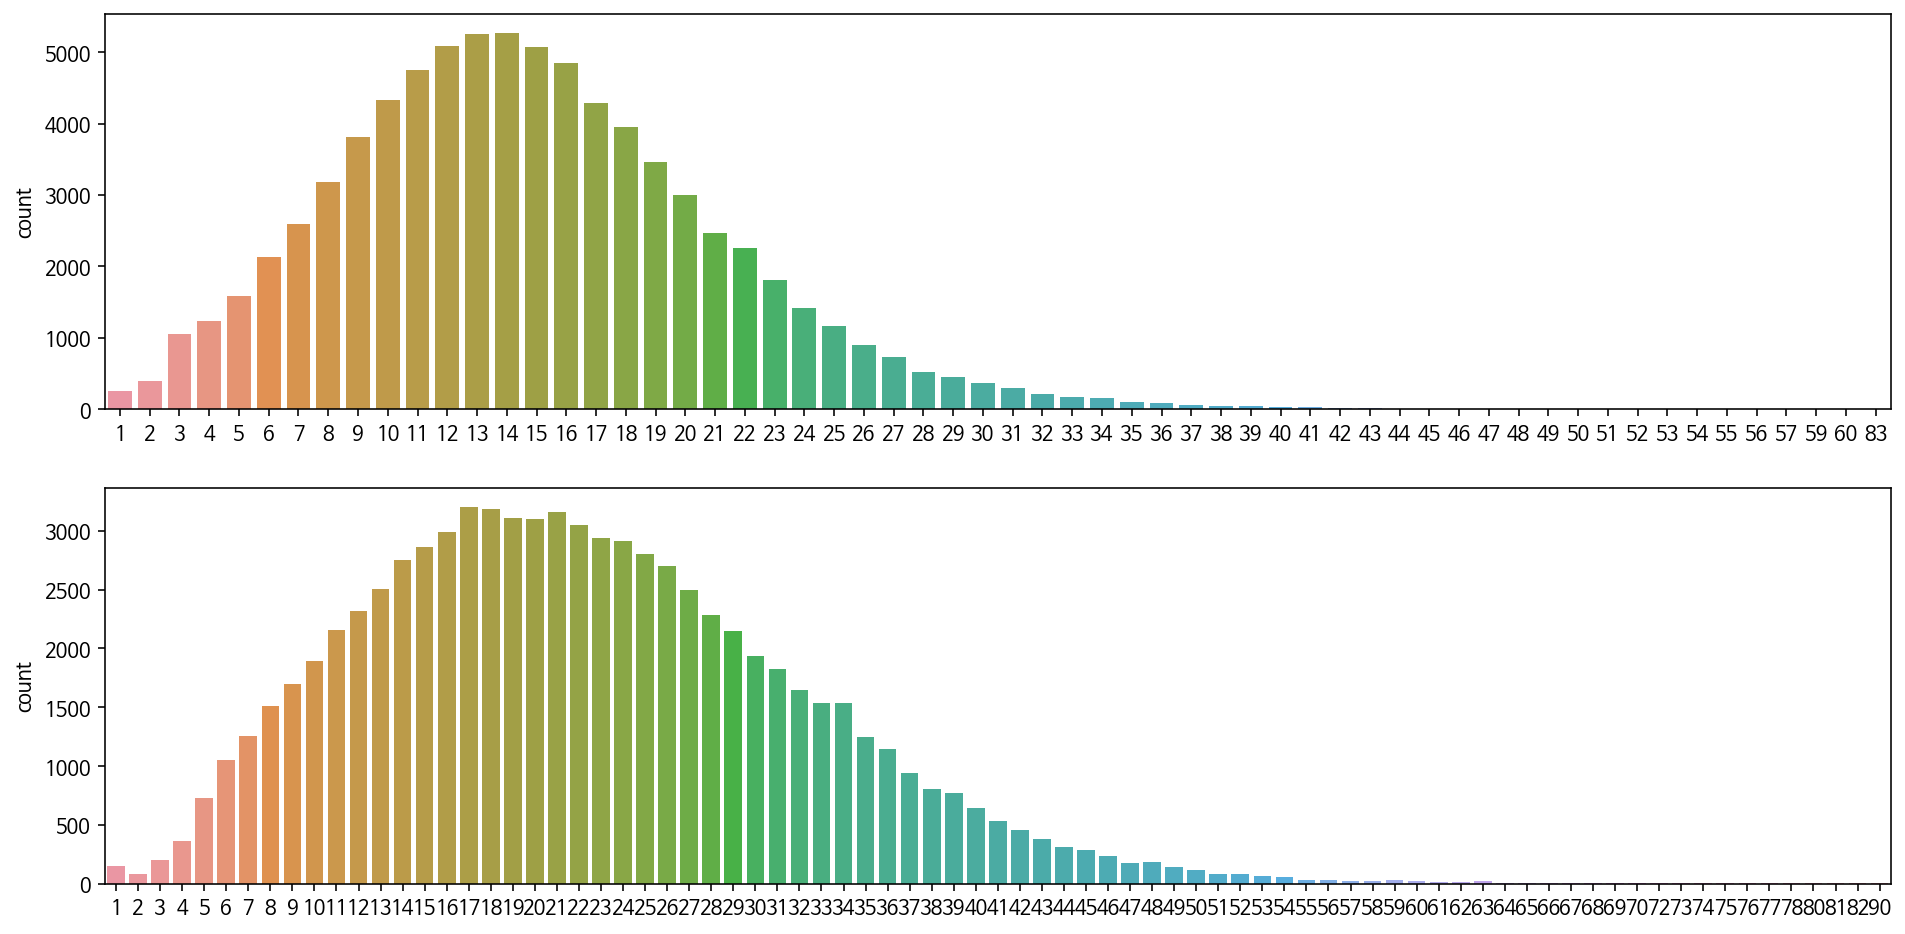

In [198]:
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.subplot(211)
sns.countplot(kor_count)
plt.subplot(212)
sns.countplot(eng_count)
plt.show()

## Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [159]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [160]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [161]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [199]:
BATCH_SIZE     = 16
SRC_VOCAB_SIZE = 15000
TGT_VOCAB_SIZE = 15000

units         = 256
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (16, 30, 256)
Decoder Output: (16, 15000)
Decoder Hidden State: (16, 256)
Attention: (16, 30, 1)


## Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

````
## 예문
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출
E1) obama is the president . \<end>
E2) people are victims of the city . \<end>
E2) the price is not enough . \<end>
E2) seven people have died . \<end>
```

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-4.max-800x600.jpg)

In [200]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [201]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [ ]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)